### Used libraries:

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### *I present to You a temperature prediction model that’s cooler than the Arctic 😎*

# ``Task Steps:``
# $ 1.$ ``Data Preprocessing & Feature Engineering``

## Reading and Understanding the DataFrame

In [105]:
df = pd.read_csv("NYC_Weather_2016_2022.csv")

print(df.info())   # There are null values in every column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59760 entries, 0 to 59759
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   59760 non-null  object 
 1   temperature_2m (°C)    59592 non-null  float64
 2   precipitation (mm)     59592 non-null  float64
 3   rain (mm)              59592 non-null  float64
 4   cloudcover (%)         59592 non-null  float64
 5   cloudcover_low (%)     59592 non-null  float64
 6   cloudcover_mid (%)     59592 non-null  float64
 7   cloudcover_high (%)    59592 non-null  float64
 8   windspeed_10m (km/h)   59592 non-null  float64
 9   winddirection_10m (°)  59587 non-null  float64
dtypes: float64(9), object(1)
memory usage: 4.6+ MB
None


In [106]:
pd.isna(df).sum() / len(df) * 100      # 168/59760 ~ 0,28% which is extremely small

time                     0.000000
temperature_2m (°C)      0.281124
precipitation (mm)       0.281124
rain (mm)                0.281124
cloudcover (%)           0.281124
cloudcover_low (%)       0.281124
cloudcover_mid (%)       0.281124
cloudcover_high (%)      0.281124
windspeed_10m (km/h)     0.281124
winddirection_10m (°)    0.289491
dtype: float64

In [107]:
df.describe()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
count,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59592.000000,59587.000000
mean,13.247721,0.133713,0.123401,45.448131,25.605702,30.109746,40.287203,11.379841,203.724420
std,9.804465,0.542782,0.525858,38.265304,37.161502,36.839594,42.526615,5.802103,99.719142
min,-18.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.200000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,7.200000,129.000000
50%,13.500000,0.000000,0.000000,35.000000,2.000000,10.000000,20.000000,10.400000,222.000000
75%,21.800000,0.000000,0.000000,89.000000,46.000000,58.000000,92.000000,14.500000,288.000000
max,35.500000,19.200000,19.200000,100.000000,100.000000,100.000000,100.000000,47.200000,360.000000


## Data Cleaning

In [109]:
# Since 0.28% of all data was null, we will drop the all null rows and replace the other not-all null values with the median if possible
df = df.dropna(how = "all")

# The time column is object type as found above, so we exclude that for median calculations
df.fillna(df.select_dtypes(exclude = "object").median(), inplace=True)

pd.isna(df).sum()    # No null values

time                     0
temperature_2m (°C)      0
precipitation (mm)       0
rain (mm)                0
cloudcover (%)           0
cloudcover_low (%)       0
cloudcover_mid (%)       0
cloudcover_high (%)      0
windspeed_10m (km/h)     0
winddirection_10m (°)    0
dtype: int64

## Time Normalization (DST Handling)

In [111]:
# New York DST
# March 9 or 8 - 03:00am- 1hr forward -
# November 2 or 1st - 02:00am- 1hr backward +

df["time"] = pd.to_datetime(df["time"])    

# print(df["time"].dtype) <- timestanp is naive so localization is needed
df["time"] = df["time"].dt.tz_localize("America/New_York", ambiguous="NaT", nonexistent="shift_forward")

# Extracting year and month from time for df splitting
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month

# Setting time as index for better and easier dst handling
df = df.set_index("time")
df.head()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),year,month
time,,,,,,,,,,,
2016-01-01 00:00:00-05:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0,2016.0,1.0
2016-01-01 01:00:00-05:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0,2016.0,1.0
2016-01-01 02:00:00-05:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0,2016.0,1.0
2016-01-01 03:00:00-05:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0,2016.0,1.0
2016-01-01 04:00:00-05:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0,2016.0,1.0


## Checking for duplicates due to DST


In [113]:
print(df.index[df.index.duplicated()])   # Since there's only 7 duplicates we can drop them all
df = df[~df.index.duplicated(keep = "first")]  

df.head()

DatetimeIndex(['2016-03-13 03:00:00-04:00', '2017-03-12 03:00:00-04:00',
                                     'NaT', '2018-03-11 03:00:00-04:00',
                                     'NaT', '2019-03-10 03:00:00-04:00',
                                     'NaT', '2020-03-08 03:00:00-04:00',
                                     'NaT', '2021-03-14 03:00:00-04:00',
                                     'NaT', '2022-03-13 03:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='time', freq=None)


,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),year,month
time,,,,,,,,,,,
2016-01-01 00:00:00-05:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0,2016.0,1.0
2016-01-01 01:00:00-05:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0,2016.0,1.0
2016-01-01 02:00:00-05:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0,2016.0,1.0
2016-01-01 03:00:00-05:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0,2016.0,1.0
2016-01-01 04:00:00-05:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0,2016.0,1.0


In [114]:
# To handle 23/25 hour days, the rows will be filled hourly and missing values will be (forward) filled by the next rows values
df = df.resample('H').asfreq()
df = df.ffill()
df.dropna(inplace = True)

## Column modifications for better model 
##### (*Season, Wind_speed, Wind_direction*)

In [116]:
# Labeling months by seasons
df["season"] = df["month"].map({
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Autumn", 10: "Autumn", 11: "Autumn"
})

df.head()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),year,month,season
time,,,,,,,,,,,,
2016-01-01 00:00:00-05:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0,2016.0,1.0,Winter
2016-01-01 01:00:00-05:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0,2016.0,1.0,Winter
2016-01-01 02:00:00-05:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0,2016.0,1.0,Winter
2016-01-01 03:00:00-05:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0,2016.0,1.0,Winter
2016-01-01 04:00:00-05:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0,2016.0,1.0,Winter


In [117]:
# Converting seasons to binary values (4 new columns) for better model training
df = pd.get_dummies(df, columns = ["season"], dtype=int)
df.rename(columns = {"season_Winter" : "Winter", "season_Summer" : "Summer", 
                     "season_Spring" : "Spring", "season_Autumn" : "Autumn"}, inplace = True)


# 0° (North),   90° (East),   180° (South),   270° (West)
# Wind direction = angle in degrees (where the wind is blowing from)
# Wind speed = magnitude (how strong the wind is)   => the two are directly correlated

# Decomposing wind direction (polar coordinate) and wind speed into cartesian components:
df["wind_u"] = df["windspeed_10m (km/h)"] * np.cos(np.radians(df["winddirection_10m (°)"]))  #speed × cos(direction) <- East–West component (x-axis)
df["wind_v"] = df["windspeed_10m (km/h)"] * np.sin(np.radians(df["winddirection_10m (°)"]))  #speed × sin(direction) <- North–South component (y-axis)
df.head()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),year,month,Autumn,Spring,Summer,Winter,wind_u,wind_v
time,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00-05:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0,2016.0,1.0,0,0,0,1,4.383711,-8.987940
2016-01-01 01:00:00-05:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0,2016.0,1.0,0,0,0,1,2.865243,-9.371787
2016-01-01 02:00:00-05:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0,2016.0,1.0,0,0,0,1,2.510545,-9.369481
2016-01-01 03:00:00-05:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0,2016.0,1.0,0,0,0,1,1.755443,-9.030970
2016-01-01 04:00:00-05:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0,2016.0,1.0,0,0,0,1,1.423554,-8.987964


## Correlation matrix for future feature selection

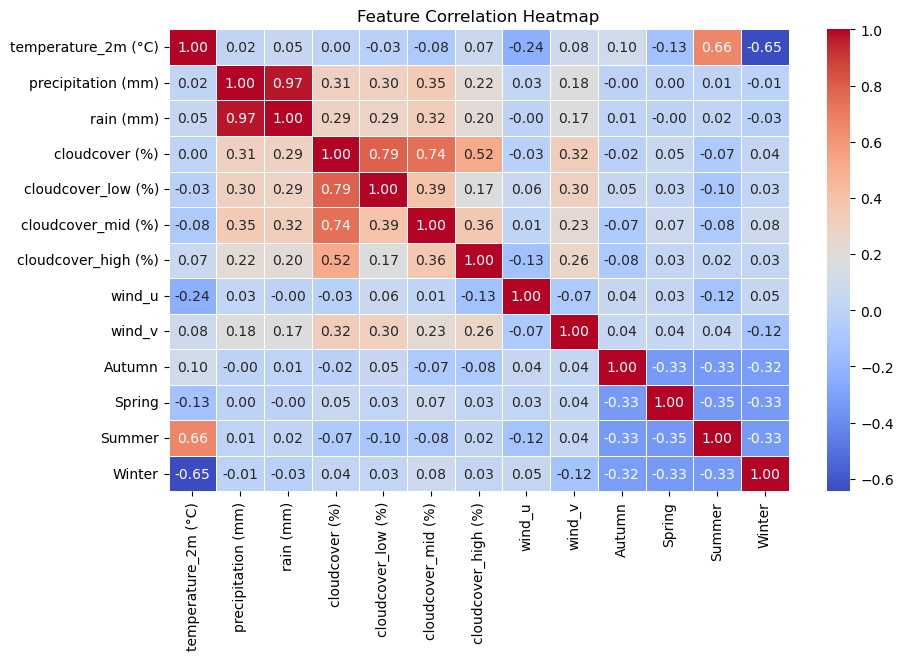

In [119]:
corr_df = df[["temperature_2m (°C)", "precipitation (mm)", "rain (mm)",
       "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)",
       "cloudcover_high (%)", "wind_u", "wind_v", "Autumn", "Spring", "Summer", "Winter"]]
corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 6))   
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
# Little information: somewhat correlation between cloudcoverages (positive) and temperature with seasons (positive/negative)

## Adding Lagged Features

In [121]:
df["temp_1hr"] = df['temperature_2m (°C)'].shift(1)
df["temp_6hr"] = df["temperature_2m (°C)"].shift(6)
df["temp_12hr"] = df["temperature_2m (°C)"].shift(12)

# Dropping NA rows created by shifting
df.dropna(inplace=True)
df.head()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),year,month,Autumn,Spring,Summer,Winter,wind_u,wind_v,temp_1hr,temp_6hr,temp_12hr
time,,,,,,,,,,,,,,,,,,,,
2016-01-01 12:00:00-05:00,4.8,0.0,0.0,80.0,56.0,0.0,99.0,9.5,261.0,2016.0,1.0,0,0,0,1,-1.486127,-9.383039,4.7,6.0,7.6
2016-01-01 13:00:00-05:00,4.6,0.0,0.0,30.0,0.0,0.0,99.0,10.1,264.0,2016.0,1.0,0,0,0,1,-1.055737,-10.044671,4.8,5.9,7.5
2016-01-01 14:00:00-05:00,4.4,0.0,0.0,29.0,0.0,0.0,96.0,11.9,272.0,2016.0,1.0,0,0,0,1,0.415304,-11.892751,4.6,5.8,7.1
2016-01-01 15:00:00-05:00,4.8,0.0,0.0,76.0,60.0,0.0,72.0,13.6,281.0,2016.0,1.0,0,0,0,1,2.595002,-13.350130,4.4,5.8,6.6
2016-01-01 16:00:00-05:00,4.7,0.0,0.0,56.0,46.0,0.0,49.0,14.4,274.0,2016.0,1.0,0,0,0,1,1.004493,-14.364922,4.8,4.7,6.3


## Relative Feature Selection

In [123]:
# Creating prediction target column
df["next_hour_pred"] = df["temperature_2m (°C)"].shift(-1)

# Selecting relative features to train the model on
relative_feat = ["temperature_2m (°C)", "rain (mm)", "precipitation (mm)",    # all columns had a positive impact on the models predictions
       "cloudcover (%)", "cloudcover_low (%)", 'cloudcover_mid (%)', 
       "cloudcover_high (%)","Autumn", "Spring", "Summer", "Winter", 
         "temp_1hr", "temp_6hr", "temp_12hr", "wind_u", "wind_v", "next_hour_pred"]

# Dropping null row created by shifting for next_hour_pred
df = df.dropna()
df.head()

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),year,...,Autumn,Spring,Summer,Winter,wind_u,wind_v,temp_1hr,temp_6hr,temp_12hr,next_hour_pred
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 12:00:00-05:00,4.8,0.0,0.0,80.0,56.0,0.0,99.0,9.5,261.0,2016.0,...,0,0,0,1,-1.486127,-9.383039,4.7,6.0,7.6,4.6
2016-01-01 13:00:00-05:00,4.6,0.0,0.0,30.0,0.0,0.0,99.0,10.1,264.0,2016.0,...,0,0,0,1,-1.055737,-10.044671,4.8,5.9,7.5,4.4
2016-01-01 14:00:00-05:00,4.4,0.0,0.0,29.0,0.0,0.0,96.0,11.9,272.0,2016.0,...,0,0,0,1,0.415304,-11.892751,4.6,5.8,7.1,4.8
2016-01-01 15:00:00-05:00,4.8,0.0,0.0,76.0,60.0,0.0,72.0,13.6,281.0,2016.0,...,0,0,0,1,2.595002,-13.350130,4.4,5.8,6.6,4.7
2016-01-01 16:00:00-05:00,4.7,0.0,0.0,56.0,46.0,0.0,49.0,14.4,274.0,2016.0,...,0,0,0,1,1.004493,-14.364922,4.8,4.7,6.3,4.9


## Splitting DataFrame by year for Training / Validation / Testing

In [125]:
training = df[df["year"] <= 2020][relative_feat]
validating = df[df["year"] == 2021][relative_feat]
testing = df[df["year"] == 2022][relative_feat]

# $2.$ ``Model Development``

## Pre-Training

In [128]:
x_train = training.drop(columns = "next_hour_pred")   # All selected features except prediction values
y_train = training["next_hour_pred"]                  # Only prediction values (same for the rest)

x_val = validating.drop(columns="next_hour_pred")
y_val = validating["next_hour_pred"]

x_test = testing.drop(columns=["next_hour_pred"])
y_test = testing["next_hour_pred"]

# Saving original testing temperatures for persistence model
current_hour_temp = testing["temperature_2m (°C)"].values[:-1]  # All columns excpet "next_hour_pred"
next_hour_temp = y_test[1:]                # Shifting by 1 to predict next hour's temperature


# Normalizing relative features (without target column: "next_hour_pred") by standard normal (better for linear regression - centering)
scaler = StandardScaler() 
training = scaler.fit_transform(x_train)
validating = scaler.transform(x_val)
testing = scaler.transform(x_test)

## Training

In [130]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

## Validation and Error Calcaluations

In [132]:
y_val_pred = model.predict(x_val)

rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\nValidation Performance:")
print(f" Validation RMSE: {rmse_val:.4f}")
print(f" Validation MAE: {mae_val:.4f}")
print(f" Validation R-squared Score: {r2_val:.4f}")


Validation Performance:
 Validation RMSE: 0.5774
 Validation MAE: 0.4050
 Validation R-squared Score: 0.9964


## Testing and Error Calcaluations

In [134]:
y_test_pred = model.predict(x_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTesting Results:")
print(f"\n Testing RMSE: {rmse_test:.4f}")
print(f" Testing MAE: {mae_test:.4f}")
print(f" Testing R-squared Score: {r2_test:.4f}")


Testing Results:

 Testing RMSE: 0.5874
 Testing MAE: 0.4198
 Testing R-squared Score: 0.9968


## Persistence Model (baseline) and Error Calcaluations

In [136]:
# Assuming nothing changed and the next hour has the same temperiture as before
persist_rmse = np.sqrt(mean_squared_error(next_hour_temp, current_hour_temp))   # Defined in Pre-Training
persist_mae = mean_absolute_error(next_hour_temp, current_hour_temp)
persist_r2 = r2_score(next_hour_temp, current_hour_temp)

print("\nPersistence Model Performance:")
print(f"\n Baseline RMSE: {persist_rmse:.4f}")
print(f" Baseline MAE: {persist_mae:.4f}")
print(f" Baseline R-squared Score: {persist_r2:.4f}")


Persistence Model Performance:

 Baseline RMSE: 1.4390
 Baseline MAE: 1.0986
 Baseline R-squared Score: 0.9806


# $3.$ ``Performance Evaluation``

## Error Calculation Between Both Models

In [139]:
print("\nModel vs. Persistence Model Comparison:")
print(f"\n VS RMSE Improvement: {(persist_rmse - rmse_test):.4f}")
print(f" VS MAE Improvement: {(persist_mae - mae_test):.4f}")
print(f" VS R-squared Improvement: {(r2_test - persist_r2):.4f}")


Model vs. Persistence Model Comparison:

 VS RMSE Improvement: 0.8516
 VS MAE Improvement: 0.6788
 VS R-squared Improvement: 0.0162


# $4.$ ``Informative Visualizations``

## Predicted vs Actual Temperatures ScatterPlot

#### Figure 1.


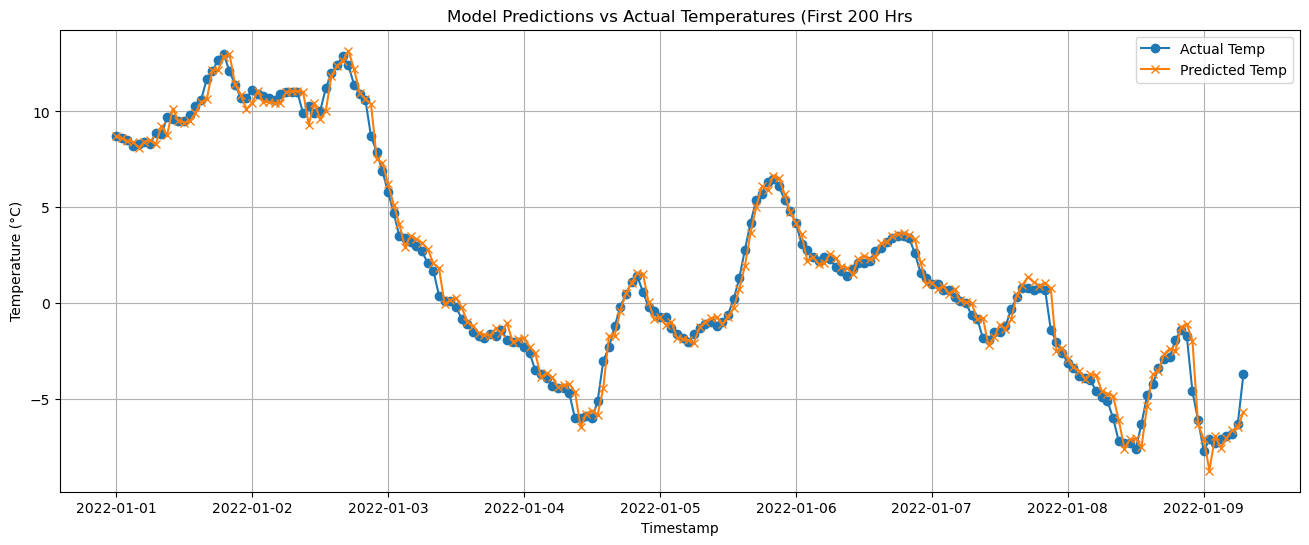

In [143]:
# Taking first 200 rows from "next_hour_pred" values (which are not normalized) for better comparison visibility
plt.figure(figsize=(16, 6))
plt.plot(y_test.index[:200], y_test.values[:200], label = "Actual Temp", marker = "o")  
plt.plot(y_test.index[:200], y_test_pred[:200], label = "Predicted Temp", marker = "x")
plt.xlabel("Timestamp")
plt.title("Model Predictions vs Actual Temperatures (First 200 Hrs")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

#### Figure 2.


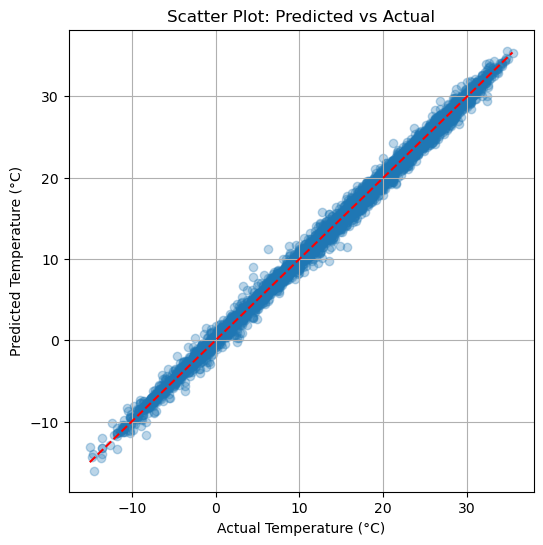

In [145]:
# Predicted(y-axis) vs Actual(x-axis) tempertures
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Scatter Plot: Predicted vs Actual")
plt.grid()
plt.show()

## Unscaling splitted dataframes: testing, training, validation

In [147]:
training_unscaled = scaler.inverse_transform(training)
validation_unscaled = scaler.inverse_transform(validating)
testing_unscaled = scaler.inverse_transform(testing)

## 2022 Temperature Comparison DataFrame
#### Model vs Actual

In [149]:
comparison_df = {"Actual_temp": y_test.values, 
                 "Model_prediction": y_test_pred, 
                 "Difference": np.round(abs(y_test.values - y_test_pred), 1)} # Taking absolute difference and rounding up to 1 decimal point

comparison_df = pd.DataFrame(comparison_df)
comparison_df.head()

,Actual_temp,Model_prediction,Difference
0,8.7,8.707283,0.0
1,8.6,8.596819,0.0
2,8.5,8.467713,0.0
3,8.2,8.416682,0.2
4,8.3,8.109881,0.2


## `Prediction accuracy % Calculations `
#### Model vs Actual
#### Precision Levels: $0.1, 0.5, 1, 100$ 

In [151]:
accuracy_01 = sum(comparison_df["Difference"] == 0.1)
accuracy_05 = sum(comparison_df["Difference"] <= 0.5)
accuracy_1 = sum(comparison_df["Difference"] <= 1)
accuracy_100 = sum(comparison_df["Difference"] == 0)
nrows = comparison_df.shape[0]

print(f"Note: There are a total of {comparison_df.shape[0]} rows.")
print("\nModel prediction accuracy % for 4 levels of precision: 0.1, 0.5, 1, 100.")
print(f"\n 0.1 Precision: {accuracy_01} values, Total Percentage: {np.round(accuracy_01 * 100 / nrows, 2)} %")
print(f" 0.5 Precision: {accuracy_05} values,  Total Percentage: {np.round(accuracy_05 * 100 /nrows, 2)} %")
print(f"   1 Precision: {accuracy_1} values,  Total Percentage: {np.round(accuracy_1 * 100 / nrows, 2)} %")
print(f" 100 Precision: {accuracy_100} values,  Total Percentage: {np.round(accuracy_100 * 100 / nrows, 2)} %")
print("\nTA-DAA! :D")

Note: There are a total of 7150 rows.

Model prediction accuracy % for 4 levels of precision: 0.1, 0.5, 1, 100.

 0.1 Precision: 1201 values, Total Percentage: 16.8 %
 0.5 Precision: 5331 values,  Total Percentage: 74.56 %
   1 Precision: 6623 values,  Total Percentage: 92.63 %
 100 Precision: 744 values,  Total Percentage: 10.41 %

TA-DAA! :D


In [179]:
# comparison_df.to_csv("Predictions_for_2022_test_set.csv", index=False)  # Saving the comparison dataframe as a csv file